# TME 6, classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [60]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import math
import random

with open('ressources/lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [61]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [62]:
# affichage d'une lettre
def tracerLettre(let,title=None):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    if title:
        plt.title(title)
    plt.plot(coord[:,0],coord[:,1])
    plt.savefig("exlettre.png")
    return

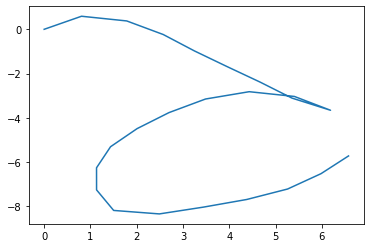

In [63]:
tracerLettre(X[0])

##  Apprentissage d'un modèle CM (max de vraisemblance)
### 1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats`
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [64]:
def discretise(x,d):
    discrete = x.copy()
    states = 360/d
    for i in range (len(x)):
        discrete[i] = np.floor(x[i]/states)
    return discrete

In [65]:
# application à la première lettre
discretise(X[0],3)
# affichage de référence : code validé

array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.])

**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2., 2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

### 2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [66]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe. 

Si j'ai bien compris, il devient possible de désigner le premier élément de la classe 1, quel que soit son indice originel, par la notation ```index[0][0]```.

### 3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [67]:
def learnMarkovModel(Xc, d):
    A = np.zeros((d,d))
    Pi = np.zeros(d)
    # ce qui suit est un algorithme de comptage. 
    # dans Pi, recensement des états initiaux.
    # dans A, recensement des transitions de ei vers ej pour tout i, j de [0,d[.
    for i in range(len(Xc)):
        lettre=Xc[i] # Xc[i] est une lettre de la base de données.
        # son tracé commence par un état donné.
        Pi[int(lettre[0])]+=1 # je dois donc augmenter l'effectif des lettres qui commencent par cet état.
        for j in range(len(lettre)-1): # puis, je parcours le reste : à chaque passage d'un état à l'autre, je me demande :
            hodie = int(lettre[j]) # dans quel état suis-je tout de suite, aujourd'hui ?
            cras = int(lettre[j+1]) # et dans quel état serai-je par la suite, demain ?
            A[hodie][cras]+=1 # incrémenter l'effectif des passages dudit état à l'autre dans la matrice de transition.
    # normalisation - l'objectif étant bien sûr d'obtenir des probabilités.
    A/=np.maximum(A.sum(1).reshape(d,1),1) 
    Pi/=Pi.sum()
    # et voilà
    return Pi, A

In [68]:
# discrétisation à trois états
Xd = discretise(X,3)
# regroupement par classe : il s'agit de pouvoir lancer l'apprentissage sur chacune séparément,
index = groupByLabel(Y)
# ici la première : dans le cas d'un alphabet, on va s'intéresser aux A seulement
learnMarkovModel(Xd[index[0]],3)

# le premier élément de l'affichage est la matrice Pi - probabilité de commencer par l'état 0, 1, ou 2.
# le second élément de l'affichage est la matrice de transition A.
# affichage de référence : code validé

(array([0.36363636, 0.        , 0.63636364]),
 array([[0.84444444, 0.06666667, 0.08888889],
        [0.        , 0.83333333, 0.16666667],
        [0.11382114, 0.06504065, 0.82113821]]))

**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

### 4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [69]:
d = 3                    # paramètre de discrétisation
Xd = discretise(X,d)     # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[index[cl]], d))

##  Test (affectation dans les classes sur critère MV)
### 1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [70]:
def probaSequence(s, Pi, A):
    # si l'on suppose les états successifs indépendants, une vraisemblance est une multiplication de probabilités.
    L=Pi[int(s[0])] # initialisation : probabilité "a priori" de commencer par l'état lu sur les starting-blocks
    for i in range(1,len(s)): # série de multiplications, grâce à...
        L*=A[int(s[i-1])][int(s[i])] # ...la récupération, dans la matrice de transition, des probabilités de passage de chaque état à celui qui suit
    return np.log(L)

In [71]:
# calcul des probabilités, pour le premier signal (discrétisé), d'appartenir à chacune des classes
# de quelle lettre s'agit-il ? réponse grâce au maximum de vraisemblance
vraisemblances = np.zeros(len(models))
for modele in range (len(models)):
    vraisemblances[modele]=probaSequence(Xd[0],models[modele][0],models[modele][1])
vraisemblances
# affichage de référence : code validé

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])

**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?
- D'où viennent tous les `-inf` ? 

Ce signal est censé être un A. Etiqueté comme tel, il est malheureusement reconnu comme un Z - la vraisemblance d'appartenance à la classe Z (26ème modèle) étant supérieure, et ce bien que celle de la classe A suive de très près.

Ci-dessous pour rire, le tracé du profil de notre cas, de deux A plus typiques, et d'un Z. L'erreur s'explique.

NB : les -inf sont accompagnés d'un avertissement à l'exécution et sont liés à la valeur mathématiquement indéfinie de log(0). Pour traduire, les classes où log(L) vaut -inf sont celles qui donnent une vraisemblance tout juste nulle.

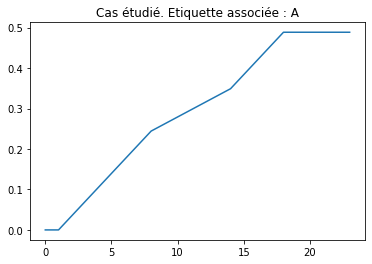

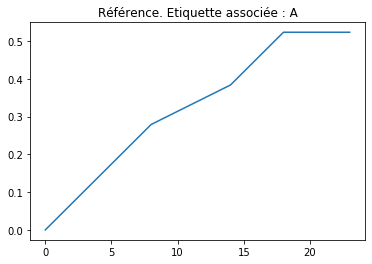

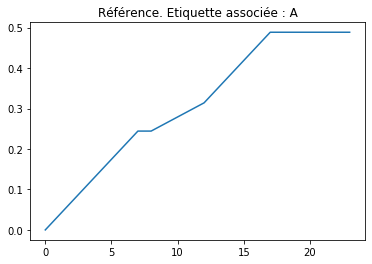

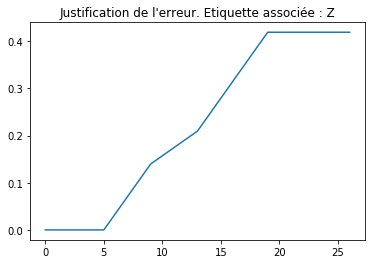

In [72]:
tracerLettre(Xd[0],"Cas étudié. Etiquette associée : A")
tracerLettre(Xd[2],"Référence. Etiquette associée : A")
tracerLettre(Xd[5],"Référence. Etiquette associée : A")
tracerLettre(Xd[260],"Justification de l'erreur. Etiquette associée : Z")

Dans leur version discrétisée, les autres A ne présentent pas cette courte plateforme au départ du signal. Les Z, si.

### 2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [73]:
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


### 3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [74]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
# calcul de la classe la plus probable :
predictions = proba.argmax(0) # max colonne par colonne
# calcul d'un pourcentage de bonne classification :
accuracy = np.where(predictions != Ynum, 0., 1.).mean()

print("Pourcentage de classifications correctes sous d =", d, ":", accuracy)
# affichage de référence : code validé
# il suffit de changer d quelques champs plus haut pour rendre compte de l'autre version

Pourcentage de classifications correctes sous d = 3 : 0.6902985074626866


**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

## Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de pallier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [31]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y,pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [75]:
itrain

[array([3, 5, 2, 1, 6, 0, 9, 7], dtype=int64),
 array([12, 16, 20, 15, 11, 21, 19, 14], dtype=int64),
 array([26, 23, 24, 31, 29, 28, 25, 22], dtype=int64),
 array([39, 42, 35, 41, 40, 37, 33, 36], dtype=int64),
 array([44, 47, 48, 50, 53, 51, 54, 45], dtype=int64),
 array([56, 57, 59, 64, 60, 63, 55, 61], dtype=int64),
 array([71, 66, 73, 70, 67, 68, 76, 75], dtype=int64),
 array([83, 78, 84, 85, 86, 79, 87, 80], dtype=int64),
 array([92, 90, 93, 89, 91, 88, 97, 96], dtype=int64),
 array([106, 101, 100,  98, 107, 102, 104, 105], dtype=int64),
 array([113, 115, 110, 116, 111, 117, 114, 108], dtype=int64),
 array([123, 122, 121, 120, 118, 127, 126, 125], dtype=int64),
 array([129, 133, 128, 132, 131, 137, 136, 134], dtype=int64),
 array([146, 147, 143, 141, 142, 138, 145, 144], dtype=int64),
 array([149, 152, 148, 151, 156, 155, 154, 153], dtype=int64),
 array([158, 159, 163, 161, 164, 160, 166, 165], dtype=int64),
 array([174, 170, 172, 177, 173, 175, 176, 171], dtype=int64),
 array([1

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

In [76]:
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()

**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

## Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

L'analyse concerne un certain nombre d'exécutions du classifieur.  
Pour répéter la mission en fonction de la discrétisation d, on utiliserait volontiers une fonction.

Or, d'un point de vue rigide, la séparation train/test des données doit être faite une seule fois pour toutes - et non pas répétée à chaque itération - si l'on veut que la comparaison entre les d soit vraiment valide. Deux choix :  
1. On s'assume rigide.   
En exécutant le code fourni plus haut, on a *déjà* séparé deux ensembles d'indices. On s'y tient.  
Côté train, la transformation a renvoyé un array de vingt-six arrays, un par classe, contenant 80% des indices de chacune.
Côté test, la transformation a renvoyé un array de vingt-six arrays, un par classe, contenant 20% des indices de chacune.  
On a reconditionné ces arrays sous la forme de deux listes. La suite des opérations va pouvoir être factorisée à condition de passer ces listes en paramètres.  


2. On décide d'inclure la séparation dans l'évaluation des performances.  
Au vu de la note ci-dessus, c'est apparemment toléré, et multiplier les essais permet d'obtenir un résultat plus représentatif  
(sinon, qui sait si la seule séparation retenue au départ n'est pas un cas de niche ?).  
Il suffit alors de repasser le morceau de code fourni à l'intérieur de la fonction.

Nous sommes, au premier abord, partisan.e du choix 1.

In [77]:
def applyPrediction(data,labels,train,test,d):  
    # les indices des groupes d'apprentissage et de test sont préétablis dans les paramètres train et test.
    # reste seulement à changer le paramètre de discrétisation d à l'appel de la fonction.
    Xd = discretise(data,d)
    
    # côté train, création du vecteur de données discrètes
    Xtrain = Xd[train]
    # création du vecteur d'étiquettes associé
    Ytrain = Y[train]
    # clarification des classes
    index = groupByLabel(Ytrain)
    # définition des modèles >>> se fait sur le train set
    models = []
    for cl in range(len(np.unique(Ytrain))):
        models.append(learnMarkovModel(Xtrain[index[cl]],d))
    
    # côté test, création du vecteur de données discrètes
    Xtest = Xd[test]
    # création du vecteur d'étiquettes associé
    Ytest = Y[test]
    # prédiction par maximum de vraisemblance >>> se fait sur le test set
    vraisemblances = np.zeros((len(Xtest),len(models)))
    for signal in range (len(Xtest)): 
        for modele in range (len(models)):
            vraisemblances[signal,modele]=probaSequence(Xtest[signal],models[modele][0],models[modele][1])

    # préparation à l'évaluation des performances
    Ynum = np.zeros(Ytest.shape)
    for num, char in enumerate(np.unique(Ytest)):
        Ynum[Ytest == char] = num
    predictions = vraisemblances.argmax(1) # repérage des maxima pour chaque ligne 
    return predictions, Ynum
    # ^ ce choix de vecteur de retour, au lieu d'avoir directement
    #      return np.where(pred != Ynum, 0.,1.).mean()
    # sera utile pour la partie optionnelle
    
# on s'intéresse maintenant à l'évolution des performances en fonction de d. 
# script de recherche du maximum
def findTopAccuracy(data,labels,train,test,verbose=False):
    # déterminer le paramètre verbose à True lors de l'appel de fonction permet de donner le détail des performances
    # on évitera pour un grand nombre d'itérations
    max = 0
    indmax = 2
    for d in range(2,32,2):
        predictions, Ynum = applyPrediction(data,labels,train,test,d)
        accuracy = np.where(predictions != Ynum, 0.,1.).mean()
        if verbose:
            print("La performance sous le paramètre de discrétisation", d, "plafonne à", accuracy*100, "% de prédictions justes.")
        if accuracy > max :
            max = accuracy
            indmax = d
    return indmax, max

In [78]:
topchoix, reussites = findTopAccuracy(X,Y,ia,it,verbose=True)
print("\nLa classification réussit au mieux pour d* =", topchoix, ".")
print("Un tel paramètre permet de reconnaître correctement", reussites*100, "% des lettres.")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


La performance sous le paramètre de discrétisation 2 plafonne à 40.0 % de prédictions justes.
La performance sous le paramètre de discrétisation 4 plafonne à 66.66666666666666 % de prédictions justes.
La performance sous le paramètre de discrétisation 6 plafonne à 65.0 % de prédictions justes.
La performance sous le paramètre de discrétisation 8 plafonne à 61.66666666666667 % de prédictions justes.
La performance sous le paramètre de discrétisation 10 plafonne à 55.00000000000001 % de prédictions justes.
La performance sous le paramètre de discrétisation 12 plafonne à 41.66666666666667 % de prédictions justes.
La performance sous le paramètre de discrétisation 14 plafonne à 33.33333333333333 % de prédictions justes.
La performance sous le paramètre de discrétisation 16 plafonne à 26.666666666666668 % de prédictions justes.
La performance sous le paramètre de discrétisation 18 plafonne à 25.0 % de prédictions justes.
La performance sous le paramètre de discrétisation 20 plafonne à 20.0 

Le classifieur a l'air incapable de gérer une grande quantité d'états possibles (d > 20), pour les raisons explicitées plus bas par vos soins. La taille de l'ensemble d'entraînement ne suffit plus : l'ensemble de test est inconnu, et il n'y a pas assez de références pour le comprendre, ce qui donne une bien piètre performance (à peine 20% de reconnaissance).  
Le maximum de prédictions justes sera d'environ 60% pour des petites valeurs de d.

### Notes additionnelles
On s'emploie à pallier les conséquences du choix fait plus haut, par un calcul de la moyenne de d* sur divers ensembles train/test : en général sur cette base, combien d'états faut-il retenir pour obtenir les meilleurs résultats ?

In [79]:
def findAverageTopAccuracy(data,labels,experiments):
    # experiments représente le nombre de répétitions de séparation/classification pour avoir une moyenne.
    # les ensembles train et test ne sont plus des paramètres, ils seront redéfinis pour chaque itération.
    indmax = 0
    max = 0
    for i in range (experiments):
        itrain, itest = separeTrainTest(labels, 0.8)
        ia = []
        for i in itrain:
            ia += i.tolist()    
        it = []
        for i in itest:
            it += i.tolist()
        b, r = findTopAccuracy(data,labels,ia,it)
        indmax += b
        max += r
    indmax /= experiments
    max /= experiments
    return indmax, max 

In [81]:
topchoix, reussites = findAverageTopAccuracy(X,Y,20)
print("En moyenne, la classification réussit au mieux pour d* =", topchoix, ".")
print("Le pourcentage de réussite est alors de", reussites*100, "%.")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


En moyenne, la classification réussit au mieux pour d* = 5.4 .
Le pourcentage de réussite est alors de 61.333333333333314 %.


## Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observé une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [93]:
# redéfinition d'une ancienne fonction
def learnMarkovModel(Xc, d):
    A = np.ones((d,d)) # c'est tout ce qui change
    Pi = np.ones(d)
    for i in range(len(Xc)):
        lettre=Xc[i] 
        Pi[int(lettre[0])]+=1
        for j in range(len(lettre)-1):
            hodie = int(lettre[j]) 
            cras = int(lettre[j+1])
            A[hodie][cras]+=1 
    A/=np.maximum(A.sum(1).reshape(d,1),1) 
    Pi/=Pi.sum()
    return Pi, A

In [43]:
print("En évitant une partie du surapprentissage...")
topchoix, reussites = findAverageTopAccuracy(X,Y,20)
print("En moyenne, la classification réussit au mieux pour d* =", topchoix, ".")
print("Le pourcentage de réussite est alors de", reussites*100, "%.")

En évitant une partie du surapprentissage...
En moyenne, la classification réussit au mieux pour d* = 10.6 .
Le pourcentage de réussite est alors de 70.58333333333333 %.


On vient de constater une amélioration claire des performances en moyenne (environ 10% de réponses correctes en plus), et ce pour des valeurs de discrétisation plus grandes (passer de d\*=5 à d\*=11, c'est savoir gérer deux fois plus d'états possibles).  
Ce n'est pas le coeur du propos. Sur un ensemble train/test fixé, intéressons-nous surtout à ce qui se passe pour de grandes valeurs de d, en lisant les dernières lignes de l'exécution suivante: 

In [44]:
findTopAccuracy(X,Y,ia,it,verbose=True)

La performance sous le paramètre de discrétisation 2 plafonne à 31.666666666666664 % de prédictions justes.
La performance sous le paramètre de discrétisation 4 plafonne à 66.66666666666666 % de prédictions justes.
La performance sous le paramètre de discrétisation 6 plafonne à 66.66666666666666 % de prédictions justes.
La performance sous le paramètre de discrétisation 8 plafonne à 70.0 % de prédictions justes.
La performance sous le paramètre de discrétisation 10 plafonne à 65.0 % de prédictions justes.
La performance sous le paramètre de discrétisation 12 plafonne à 61.66666666666667 % de prédictions justes.
La performance sous le paramètre de discrétisation 14 plafonne à 60.0 % de prédictions justes.
La performance sous le paramètre de discrétisation 16 plafonne à 61.66666666666667 % de prédictions justes.
La performance sous le paramètre de discrétisation 18 plafonne à 65.0 % de prédictions justes.
La performance sous le paramètre de discrétisation 20 plafonne à 66.66666666666666 

(8, 0.7)

On les compare à ce qui avait été obtenu plus haut.  
Pour de grands d, les taux de réponses correctes ont été triplés (0.2 -> 0.6 %).  
Le surapprentissage a donc été vaillamment combattu en supprimant au moins les risques de vraisemblance nulle : le modèle ne colle plus _exactement_ aux données étiquetées, ce qui lui laisse une marge de manoeuvre pour en reconnaître de nouvelles.

# Partie optionnelle
## Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [83]:
confusion = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

In [84]:
d = 11
predictions, Ynum = applyPrediction(X,Y,ia,it,d)
# le choix de d est orienté par les résultats précédents, où d* valait 11.
for i in range(len(Ynum)):
    confusion[int(predictions[i])][int(Ynum[i])] += 1

- Tracé de la matrice : 

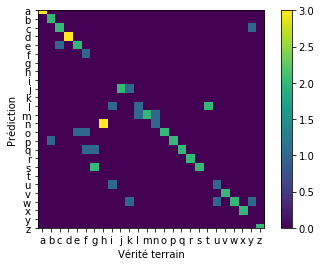

In [85]:
plt.figure()
plt.imshow(confusion, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
plt.savefig("mat_conf_lettres.png")

Plus le signal est clair, plus il y a de correspondances à une position donnée (intersection de la ligne (prédiction) avec la colonne de même indice (ce qu'on attend, vérité terrain)).  
Les erreurs sont les signaux qui divergent de la diagonale.  
Par exemple, ce classifieur a une drôle de tendance à prendre les h pour des n.  
Il y a des lettres pour lesquelles il ne se trompe jamais, c'est le cas du d, du a, du s entre autres.

## Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [94]:
def tirageDiscret(Pi):
    # somme cumulée
    sc = np.cumsum(Pi)
    # tirage entre 0 et 1
    t = random.random()
    # recherche de dépassement
    for i in range(len(sc)):
        if sc[i] > t:
            return i
    # et s'il n'y a pas de dépassement,
    # il faut bien retourner quelque chose
    return len(sc)-1

def genereSequence(Pi,A,No):
    tirage = []
    # tirer un état selon les probabilités initiales
    tirage.append(tirageDiscret(Pi))
    for i in range(No-1):
        hodie = tirage[i]
        # tirer un successeur selon la loi de probabilité associée à l'état courant
        tirage.append(tirageDiscret(A[hodie]))
    return tirage

In [144]:
# pour générer des lettres, retour à la situation initiale
# en ce qui concerne le surapprentissage
# redéfinition de 
def learnMarkovModel(Xc, d):
    A = np.zeros((d,d)) # c'est tout ce qui change
    Pi = np.zeros(d)
    for i in range(len(Xc)):
        lettre=Xc[i] 
        Pi[int(lettre[0])]+=1
        for j in range(len(lettre)-1):
            hodie = int(lettre[j]) 
            cras = int(lettre[j+1])
            A[hodie][cras]+=1 
    A/=np.maximum(A.sum(1).reshape(d,1),1) 
    Pi/=Pi.sum()
    return Pi, A

### Affichage du résultat

Un air de famille avec la classe n° 0 ----


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


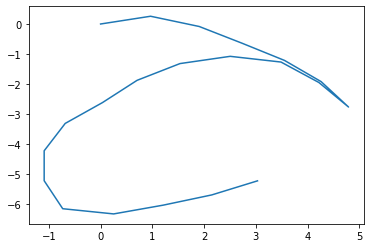

In [233]:
# il est nécessaire de recalculer les vingt-six modèles pour le d choisi
# on a envie de tenter d=360 pour obtenir un affichage visuellement reconnaissable, au plus près des valeurs d'entraînement.
# de fait, ayant essayé, c'est encore pire avec une discrétisation plus large.

d = 360                  # paramètre de discrétisation
Xd = discretise(X,d)     # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[index[cl]], d))

newa = genereSequence(models[0][0],models[0][1],20)      # génération d'une séquence de vingt états pour un A
intervalle = 360./d                                      # pour passer des états => valeur d'angles
newa_continu = np.array([i * intervalle for i in newa])  # conv int => double
tracerLettre(newa_continu)

# le classifieur reconnaît-il ce qu'il a généré ?
vraisemblances = np.zeros(len(models))
for modele in range (len(models)):
    vraisemblances[modele]=probaSequence(newa,models[modele][0],models[modele][1])
print("Un air de famille avec la classe n°", vraisemblances.argmax(0), "----")

C'est à peu près réussi - ça ne l'est pas toujours.
Ci-dessous, une lettre r :

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Un air de famille avec la classe n° 17 ----


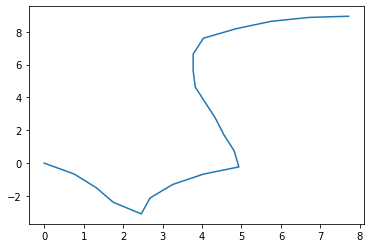

In [920]:
newr = genereSequence(models[17][0],models[17][1],20)    # génération d'une séquence de vingt états pour un A
intervalle = 360./d                                      # pour passer des états => valeur d'angles
newr_continu = np.array([i * intervalle for i in newr])  # conv int => double
tracerLettre(newr_continu)

vraisemblances = np.zeros(len(models))
for modele in range (len(models)):
    vraisemblances[modele]=probaSequence(newr_continu,models[modele][0],models[modele][1])
print("Un air de famille avec la classe n°", vraisemblances.argmax(0), "----")

On ne se prononcera pas sur la qualité des échantillons de départ. Il y aurait à redire.  
Ce qui est certain, c'est que ce que le classifieur voit - et qui lui permet d'établir une prédiction juste - n'a que peu de rapport avec ce que rend la vision humaine.

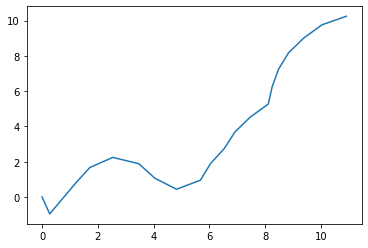

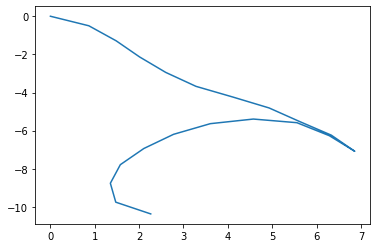

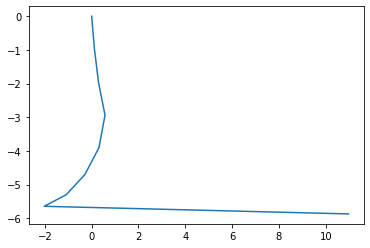

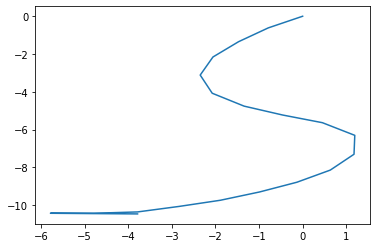

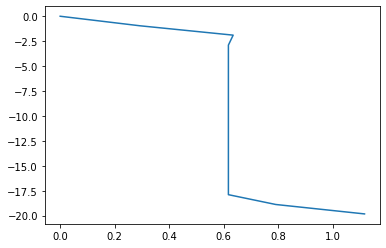

In [859]:
# mapsi !

newm = genereSequence(models[12][0],models[12][1],20)    
intervalle = 360./d                                      
newm_continu = np.array([i * intervalle for i in newm]) 
tracerLettre(newm_continu)

newa = genereSequence(models[0][0],models[0][1],20)      
intervalle = 360./d                                      
newa_continu = np.array([i * intervalle for i in newa]) 
tracerLettre(newa_continu)

newp = genereSequence(models[15][0],models[15][1],20)    
intervalle = 360./d                                     
newp_continu = np.array([i * intervalle for i in newp]) 
tracerLettre(newp_continu)

news = genereSequence(models[18][0],models[18][1],20)    
intervalle = 360./d                                     
news_continu = np.array([i * intervalle for i in news]) 
tracerLettre(news_continu)

newi = genereSequence(models[8][0],models[8][1],20)      
intervalle = 360./d                                     
newi_continu = np.array([i * intervalle for i in newi]) 
tracerLettre(newi_continu)